# Figure 1: Adhesome genes/loci are close in HiC

In [173]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [174]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# RNAseq directory
dir_rna = '/home/louiscam/projects/gpcr/data/bulk_rnaseq/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [175]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Using bulk RNAseq

### Load gene data

In [176]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc['geneLength'] = df_loc['chromEnd']-df_loc['chromStart']
genes_df = df_loc[['geneSymbol', 'geneLength']].set_index('geneSymbol')

In [177]:
# Active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))
# Active/inactive genes
active_genes = pickle.load(open(saving_dir+'active_genes.pkl','rb'))
inactive_genes = pickle.load(open(saving_dir+'inactive_genes.pkl','rb'))

In [178]:
# Adhesome genes
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl','rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl','rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))

### Load IMR90 bulk RNAseq data

In [205]:
# Load full data 
full_rnaseq = pd.read_csv(dir_rna+'GSE180361_genes_counts.txt', sep='\t', header=0, index_col=0)
full_rnaseq.columns

Index(['IM_p16_1', 'IM_p16_2', 'IM_p16_3', 'IM_v_1', 'IM_v_2', 'IM_v_3',
       'Kera_L.Ras_1', 'Kera_L.Ras_2', 'Kera_L.Ras_3', 'Kera_L.Ras_4',
       'Kera_L.Ras_5', 'Kera_L.Ras_6', 'Kera_L.v_1', 'Kera_L.v_2',
       'Kera_L.v_3', 'Kera_L.v_4', 'Kera_L.v_5', 'Kera_L.v_6', 'Symbol',
       'Geneid'],
      dtype='object')

In [206]:
# Normalize to TPM
rnaseq = full_rnaseq.loc[:,['IM_p16_1', 'IM_p16_2', 'IM_p16_3', 'IM_v_1', 'IM_v_2', 'IM_v_3']].set_index(full_rnaseq['Symbol'])
genes2select = sorted(set(genes_df.index.values).intersection(set(rnaseq.index.values)))
rnaseq = rnaseq.loc[genes2select,:]
rnaseq = rnaseq.div(genes_df['geneLength'], axis=0)
rnaseq = rnaseq.div(rnaseq.sum(axis=0), axis=1)*1e6
rnaseq = np.log(1+rnaseq)
rnaseq = rnaseq.dropna(axis=0, how='any')

### Analyze correlation of adhesome genes

In [270]:
# Coregulation of adhesome genes
rnaseq_adhesome = rnaseq.loc[active_adhesome_genes,:]
# Drop adhesome gene if it has 0 variance
rnaseq_adhesome_std = rnaseq_adhesome.std(axis=1)
genes2drop = rnaseq_adhesome.index.values[np.where(rnaseq_adhesome_std==0)[0]]
genes2keep = rnaseq_adhesome.index.values[np.where(rnaseq_adhesome_std!=0)[0]]
print('Adhesome genes with 0 variance = '+str(genes2drop))
rnaseq_adhesome = rnaseq_adhesome.loc[genes2keep,:]
S_adhesome = rnaseq_adhesome.T.corr(method='pearson').values

Adhesome genes with 0 variance = []


In [271]:
# Coregulation of all active non adhesome genes
random.seed(13)
random_genes = list(set(rnaseq.index.values)-set(active_adhesome_genes)-set(inactive_adhesome_genes)-set(inactive_genes))
rnaseq_random = rnaseq.loc[random_genes,:]
# Drop adhesome gene if it has 0 variance
rnaseq_random_std = rnaseq_random.std(axis=1)
genes2drop = rnaseq_random.index.values[np.where(rnaseq_random_std==0)[0]]
genes2keep = rnaseq_random.index.values[np.where(rnaseq_random_std!=0)[0]]
print('Adhesome genes with 0 variance = '+str(genes2drop))
rnaseq_random = rnaseq_random.loc[genes2keep,:]
S_random1 = rnaseq_random.T.corr(method='pearson').values

Adhesome genes with 0 variance = ['IL34' 'BATF' 'MIR191' 'KRTAP1-3' 'HSH2D' 'TRAF3IP3' 'PYHIN1' 'FAM138B'
 'FAM25A' 'MIR4727' 'TSPAN16' 'TTLL6' 'RNU12' 'TMEM239' 'BRWD1-AS1'
 'MIR548H2' 'GABRR3' 'ADH1B' 'MIR3200' 'MIR4257' 'MIR648' 'MIR5580'
 'TMPRSS2' 'CPA3' 'MIR10A' 'NT5C1B-RDH14' 'SLC25A18' 'MIR5191' 'NOX3'
 'MIR5094' 'CLN3' 'ERP27' 'FGF14-IT1' 'CHODL-AS1' 'MIR142' 'MIR548H4'
 'MIR548Q' 'RNU5F-1' 'LINC00905' 'ANGPTL3' 'G6PC' 'RNF113B' 'SLC8A2'
 'AQP7' 'EPS8L3' 'PSORS1C3' 'MIR554' 'LINC00351' 'ASIP' 'ABCA9'
 'TMED7-TICAM2' 'ALX4' 'DDC' 'FGD2' 'SSMEM1' 'MIR548J' 'NDUFC2-KCTD14'
 'RGS13' 'SNX31' 'LINC00940' 'PARVG' 'LRRC37A11P' 'LZTS1-AS1' 'MIR611'
 'LINC00499' 'REG4' 'MIR423' 'FMO2' 'RHO' 'MIR548G' 'ADORA2A-AS1'
 'MIR4280' 'TSKS' 'ROPN1' 'MIR548AC' 'LINC00906' 'A4GNT' 'SNORA21'
 'KRTAP4-7' 'CACNG2' 'MIR548O2' 'MFRP' 'TMEM72' 'OR51T1' 'CLRN1-AS1' 'MIA'
 'LINC00563' 'OFCC1' 'ABRA' 'MACC1-AS1' 'LNX1-AS1' 'CARD18' 'MMP20'
 'MRPL30' 'TMEM105' 'ZAR1L' 'PLSCR2' 'UGT1A4' 'EPHA1-AS1' 'MIR4710'

In [272]:
# Coregulation of all non adhesome genes
random.seed(13)
random_genes = list(set(rnaseq.index.values)-set(active_adhesome_genes)-set(inactive_adhesome_genes))
rnaseq_random = rnaseq.loc[random_genes,:]
# Drop adhesome gene if it has 0 variance
rnaseq_random_std = rnaseq_random.std(axis=1)
genes2drop = rnaseq_random.index.values[np.where(rnaseq_random_std==0)[0]]
genes2keep = rnaseq_random.index.values[np.where(rnaseq_random_std!=0)[0]]
print('Adhesome genes with 0 variance = '+str(genes2drop))
rnaseq_random = rnaseq_random.loc[genes2keep,:]
S_random2 = rnaseq_random.T.corr(method='pearson').values

Adhesome genes with 0 variance = ['MIR376C' 'MIR5583-1' 'MIR1228' ... 'MIR4295' 'GLT6D1' 'WFDC8']


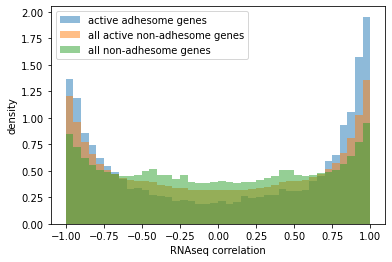

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=-11.480044160944809, pvalue=1.661956135811306e-30)


In [274]:
# Plot histogram of co-regulation
plt.figure()
plt.hist(S_adhesome[np.triu_indices(len(S_adhesome),1)], bins=np.arange(-1,1.05, 0.05), alpha=0.5, density=True, label='active adhesome genes')
plt.hist(S_random1[np.triu_indices(len(S_random1),1)], bins=np.arange(-1,1.05, 0.05), alpha=0.5, density=True, label='all active non-adhesome genes')
plt.hist(S_random2[np.triu_indices(len(S_random2),1)], bins=np.arange(-1,1.05, 0.05), alpha=0.5, density=True, label='all non-adhesome genes')
#plt.yscale('log')
plt.xlabel('RNAseq correlation')
plt.ylabel('density')
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(S_random1[np.triu_indices(len(S_random1),1)],
                  S_adhesome[np.triu_indices(len(S_adhesome),1)]))

# Using regulatory features

In [262]:
# Load regulatory features for all genes
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)

In [263]:
# Coregulation of adhesome genes
df_adhesome = df_all_norm.T.loc[active_adhesome_genes,:]
# Drop adhesome gene if it has 0 variance
df_adhesome_std = df_adhesome.std(axis=1)
genes2drop = df_adhesome.index.values[np.where(df_adhesome_std==0)[0]]
genes2keep = df_adhesome.index.values[np.where(df_adhesome_std!=0)[0]]
print('Adhesome genes with 0 variance = '+str(genes2drop))
df_adhesome = df_adhesome.loc[genes2keep,:]
S_adhesome = df_adhesome.T.corr(method='pearson').values

Adhesome genes with 0 variance = []


In [264]:
# Coregulation of all active non adhesome genes
random_genes = list(set(rnaseq.index.values)-set(active_adhesome_genes)-set(inactive_adhesome_genes)-set(inactive_genes))
df_random = df_all_norm.T.loc[random_genes,:]
# Drop adhesome gene if it has 0 variance
df_random_std = df_random.std(axis=1)
genes2drop = df_random.index.values[np.where(df_random_std==0)[0]]
genes2keep = df_random.index.values[np.where(df_random_std!=0)[0]]
print('Adhesome genes with 0 variance = '+str(genes2drop))
df_random = df_random.loc[genes2keep,:]
S_random1 = df_random.T.corr(method='pearson').values

Adhesome genes with 0 variance = []


In [265]:
# Coregulation of all non adhesome genes
random_genes = list(set(rnaseq.index.values)-set(active_adhesome_genes)-set(inactive_adhesome_genes))
df_random = df_all_norm.T.loc[random_genes,:]
# Drop adhesome gene if it has 0 variance
df_random_std = df_random.std(axis=1)
genes2drop = df_random.index.values[np.where(df_random_std==0)[0]]
genes2keep = df_random.index.values[np.where(df_random_std!=0)[0]]
print('Adhesome genes with 0 variance = '+str(genes2drop))
df_random = df_random.loc[genes2keep,:]
S_random2 = df_random.T.corr(method='pearson').values

Adhesome genes with 0 variance = []


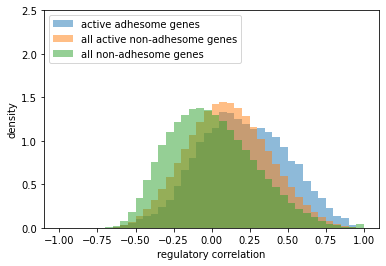

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=-45.75375816236198, pvalue=0.0)


In [269]:
# Plot histogram of co-regulation
plt.figure()
plt.hist(S_adhesome[np.triu_indices(len(S_adhesome),1)], bins=np.arange(-1,1.05, 0.05), alpha=0.5, density=True, label='active adhesome genes')
plt.hist(S_random1[np.triu_indices(len(S_random1),1)], bins=np.arange(-1,1.05, 0.05), alpha=0.5, density=True, label='all active non-adhesome genes')
plt.hist(S_random2[np.triu_indices(len(S_random2),1)], bins=np.arange(-1,1.05, 0.05), alpha=0.5, density=True, label='all non-adhesome genes')
#plt.yscale('log')
plt.xlabel('regulatory correlation')
plt.ylabel('density')
plt.legend(loc='upper left')
plt.ylim(0,2.5)
plt.show()
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(S_random1[np.triu_indices(len(S_random1),1)],
                  S_adhesome[np.triu_indices(len(S_adhesome),1)]))

# Recover adhesome genes from regulatory clustering

In [304]:
# Create distance between all genes
distance_df = (1-df_all_norm.loc[:,active_genes].corr(method='pearson'))/2

In [305]:
# Run hierarchical clustering
dist_mat = distance_df.values
labels = distance_df.index.values
y = dist_mat[np.triu_indices(n=len(dist_mat),k=1)]
linked1 = linkage(y, method='average')

<Figure size 432x288 with 0 Axes>

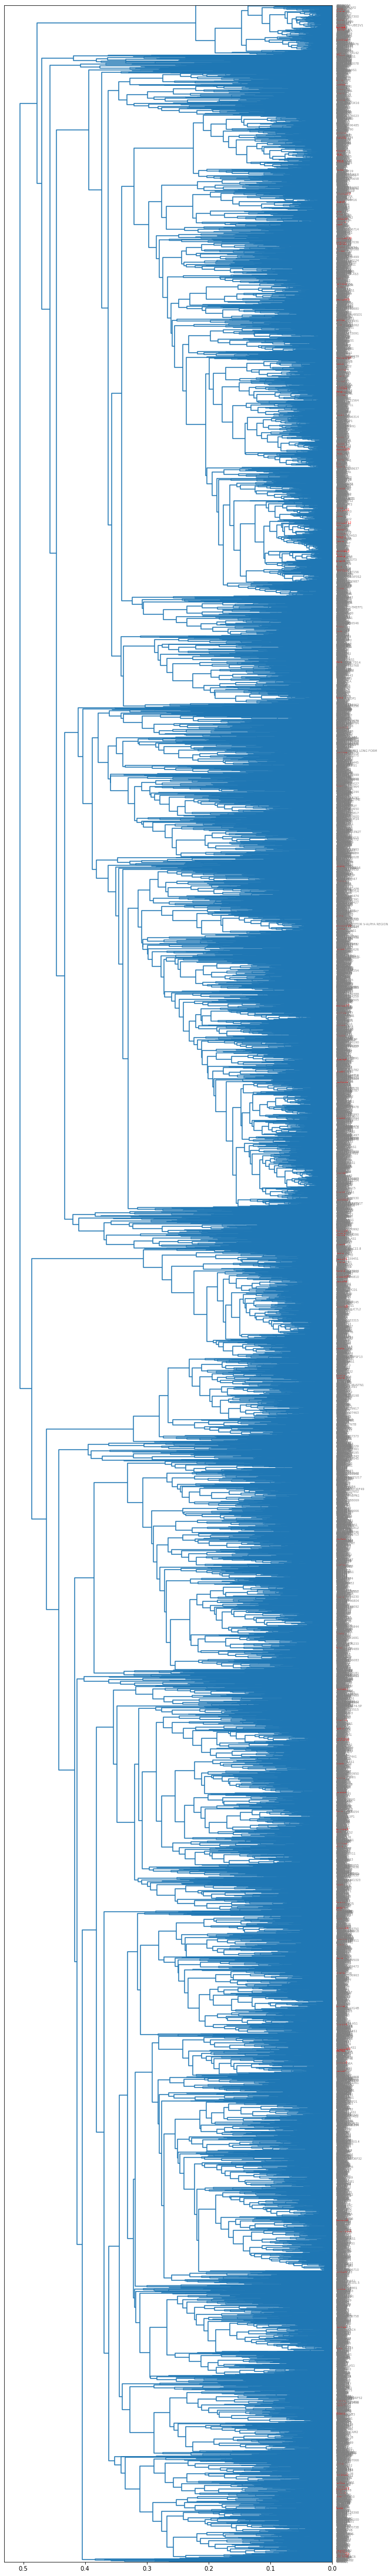

In [307]:
# Plot dendrogram
plt.clf()
plt.figure(figsize=(10,80))
ddata = dendrogram(linked1,
                   orientation='left',
                   labels=labels,
                   distance_sort='descending',
                   show_leaf_counts=True,
                   leaf_font_size=5,
                   color_threshold=0)
label_colors = {g: 'red' if g in active_adhesome_genes else 'grey' for g in labels}
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_colors[lbl.get_text()])
#plt.vlines(x=0, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

In [357]:
# Analyse clustering of active adhesome genes
N = 100
t_list = np.arange(0,0.5,0.01)
r_df = pd.DataFrame(columns=t_list)
random.seed(13)
for n in tqdm(range(N)):
    random_genes = random.sample(list(labels), len(active_adhesome_genes))
    r_list = []
    for t in t_list:
        # Obtain HC clustering with threshold t
        clust1 = fcluster(linked1, t, criterion='distance')
        clust1_df = pd.DataFrame({'gene': labels, 'cluster': clust1})
        # Number of clusters containing adhesome genes
        n_clusters_adhesome = clust1_df[clust1_df['gene'].isin(active_adhesome_genes)]['cluster'].nunique()
        n_clusters_random = clust1_df[clust1_df['gene'].isin(random_genes)]['cluster'].nunique()
        r = n_clusters_adhesome/n_clusters_random
        r_list.append(r)
    r_df = pd.concat([r_df,pd.DataFrame(np.array(r_list), index=t_list, columns=[n]).T])

100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


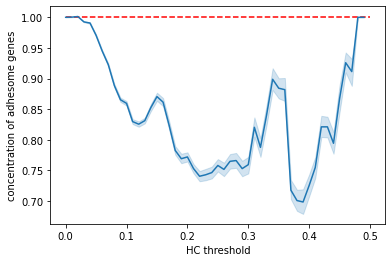

In [358]:
# Plot concentration of adhesome genes vs HC threshold
r_melted = r_df.T.reset_index().melt(id_vars='index').sort_values(by=['index','variable'])
r_melted.columns = ['hc_threshold', 'rep_id', 'r']
plt.figure()
sns.lineplot(data=r_melted, x='hc_threshold', y="r")
plt.hlines(y=1, xmin=0, xmax=0.5, color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('concentration of adhesome genes')
plt.show()

In [359]:
# Clustering for t=0.25
clust1 = fcluster(linked1, 0.25, criterion='distance')
clust1_df = pd.DataFrame({'gene': labels, 'cluster': clust1})

In [397]:
# Display important clusters
clusters_df = clust1_df[clust1_df['gene'].isin(active_adhesome_genes)].sort_values(by=['cluster','gene']).groupby('cluster')['gene'].apply(list).reset_index()
clusters_df.columns = ['cluster','adhesome_genes']
clusters_df['n_adhesome'] = [len(c) for c in clusters_df['adhesome_genes']]
clusters_df = clusters_df.set_index('cluster').join(clust1_df.groupby('cluster').nunique(), how='left')
clusters_df['pct_adhesome'] = clusters_df['n_adhesome']/clusters_df['gene']
clusters_df = clusters_df.sort_values(by='pct_adhesome', ascending=False)
clusters_df.columns = ['adhesome_genes', 'n_adhesome_genes', 'n_all_genes', 'pct_adhesome_in_cluster']
important_clusters = clusters_df[(clusters_df['pct_adhesome_in_cluster']>len(active_adhesome_genes)/len(active_genes)) & (clusters_df['n_adhesome_genes']>1)]
important_clusters

adhesome_genes  n_adhesome_genes  \
cluster                                                                        
180                                          [ITGAE, LDB3]                 2   
444                                     [SLC16A3, TGFB1I1]                 2   
439              [ARHGEF2, LIMS2, PARVB, SRC, TRPM7, VASP]                 6   
373                              [CD151, CSK, GIT1, SIRPA]                 4   
356                                         [ARF1, PTPN11]                 2   
265                                  [ITGA1, NRP2, SLC9A1]                 3   
59       [FERMT2, ITGA3, LYN, MAPK8IP3, NEDD9, PLEC, PP...                 9   
65                                          [CD47, SPTLC1]                 2   
1        [ACTN1, ADAM12, BCAR1, CAPN2, ITGA2, LPP, MYH9...                11   
441                                           [CALR, CRKL]                 2   
426               [CASP8, HSPB1, ILK, KEAP1, MMP14, TENC1]                 6   
438                                       [LIMK1, PIP5K1C]                 2   
70       [ABI2, ANKRD28, ARHGAP24, ARHGEF12, BCAR3, CAS...                43   
57       [ABL1, ASAP2, DOCK1, ENAH, IRS1, LRP1, NF2, RO...                10   
199                                [ARHGAP26, PAK1, TIAM1]                 3   
387                 [ARPC2, GNB2L1, ITGB1BP1, RHOA, SDCBP]                 5   
353                           [ILKAP, NDEL1, SHARPIN, VIM]                 4   
77                                             [EZR, GRB2]                 2   
379                                          [MARCKS, PVR]                 2   
64                                   [ITGA10, ITGB8, LPXN]                 3   
443                                        [NISCH, PRKACA]                 2   
354                                   [CAPN1, PKD1, SH2B1]                 3   
380                                         [FBLIM1, SHC1]                 2   
66                                   [ARHGAP5, KTN1, THY1]                 3   

         n_all_genes  pct_adhesome_in_cluster  
cluster                                        
180                4                 0.500000  
444               21                 0.095238  
439               67                 0.089552  
373               57                 0.070175  
356               35                 0.057143  
265               59                 0.050847  
59               180                 0.050000  
65                45                 0.044444  
1                255                 0.043137  
441               48                 0.041667  
426              158                 0.037975  
438               54                 0.037037  
70              1373                 0.031318  
57               333                 0.030030  
199              121                 0.024793  
387              204                 0.024510  
353              177                 0.022599  
77                91                 0.021978  
379               92                 0.021739  
64               163                 0.018405  
443              112                 0.017857  
354              178                 0.016854  
380              120                 0.016667  
66               183                 0.016393

In [398]:
len(active_adhesome_genes)/len(active_genes)

0.014957264957264958